In [2]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf


In [3]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [4]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## データの準備など

In [5]:
# データ準備
gmn_parray = pd.read_csv("../data/3-9-1-germination.csv")
gmn_parray["gmn_ratio"] = gmn_parray["germination"] / gmn_parray["size"] # 目的変数を作成
gmn_df = pd.DataFrame(gmn_parray)

print(gmn_df.shape)
display(gmn_df.head())

(100, 5)


,germination,size,solar,nutrition,gmn_ratio
0,0,10,shade,1,0.0
1,0,10,shade,1,0.0
2,0,10,shade,1,0.0
3,0,10,shade,1,0.0
4,0,10,shade,1,0.0


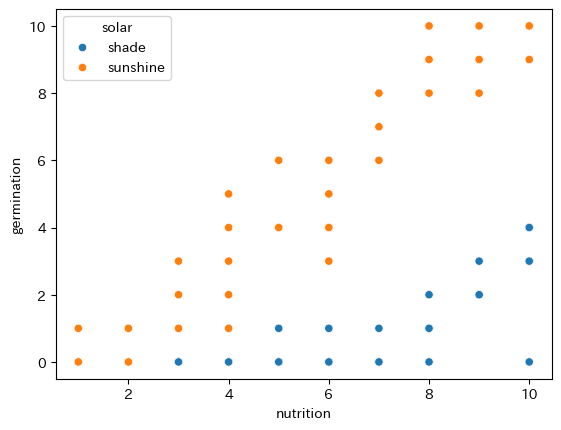

In [6]:
# データの可視化
fig, ax = plt.subplots()
ax = sns.scatterplot(x = gmn_parray["nutrition"], y = gmn_parray["germination"],
                     hue = gmn_parray["solar"])

In [7]:
# データの準備
y = gmn_parray["germination"].values
size = gmn_parray["size"]
X_dum_df = pd.get_dummies(gmn_parray.drop(["gmn_ratio", "size", "germination"], axis=1), dtype=int, drop_first=True)
col_li = X_dum_df.columns # 説明変数の次元指定用に取得
X = X_dum_df.values

print(y.shape)
print(y[:10])
print(X.shape)
print(X[:10])
print(col_li)

(100,)
[0 0 0 0 0 0 0 0 0 0]
(100, 2)
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]]
Index(['nutrition', 'solar_sunshine'], dtype='object')


## ベイズ推論

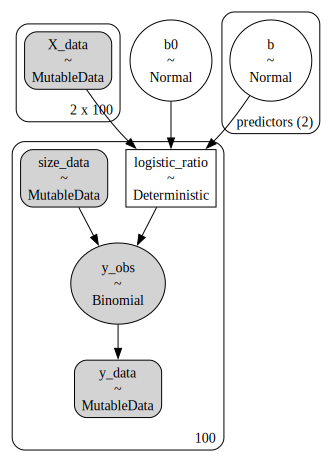

In [8]:
# 確率モデルの定義
model = pm.Model(coords={"predictors":col_li})

with model:
    # 観測値をDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    X_data = pm.Data("X_data", X.T, mutable=True)
    size_data = pm.Data("size_data", size, mutable=True)

    # パラメータの事前分布を定義
    b0 = pm.Normal("b0", mu=0, sigma=10000)
    b = pm.Normal("b", mu=0, sigma=10000, dims="predictors") # 仮説は無いので一括で同様に設定

    # 目的変数の期待値を確率変数として定義
    logistic_ratio = pm.Deterministic("logistic_ratio", 1 / (1 + pt.exp(-(b @ X_data + b0))))
    # logistic_ratio = pm.Deterministic("logistic_ratio", 
    #                                  pm.invlogit(b @ X_data + b0))

    # 観測値を持つ確率変数として定義
    y_obs = pm.Binomial("y_obs", p=logistic_ratio, n=size_data, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [9]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 3000,
        draws = 1000,
        random_seed = 42,
        
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


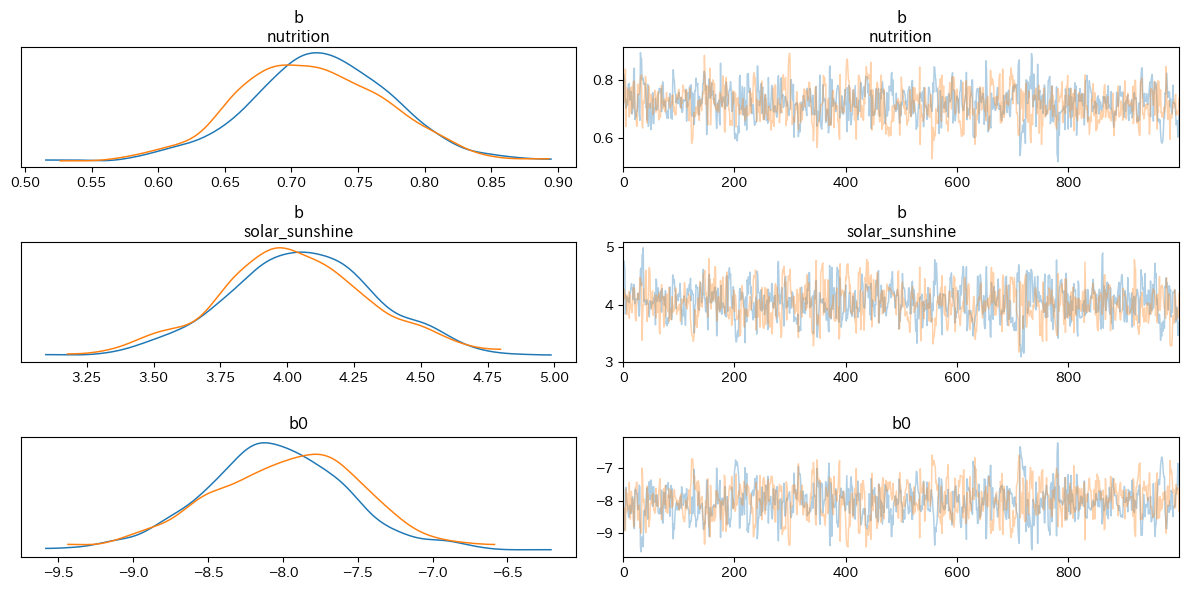

In [10]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b", "b0"])
plt.tight_layout();

In [11]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b", "b0"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[nutrition],0.719,0.055,0.615,0.822,0.002,0.002,602.0,668.0,1.01
b[solar_sunshine],4.042,0.288,3.521,4.616,0.011,0.008,643.0,726.0,1.01
b0,-8.011,0.517,-9.123,-7.123,0.022,0.015,581.0,551.0,1.01


### オッズ比の分布

In [21]:
# パラメーターのサンプリング取得
n_b = idata1["posterior"]["b"].values.reshape(-1, 2)[:, 0]
s_b = idata1["posterior"]["b"].values.reshape(-1, 2)[:, 1]

<Axes: ylabel='Density'>

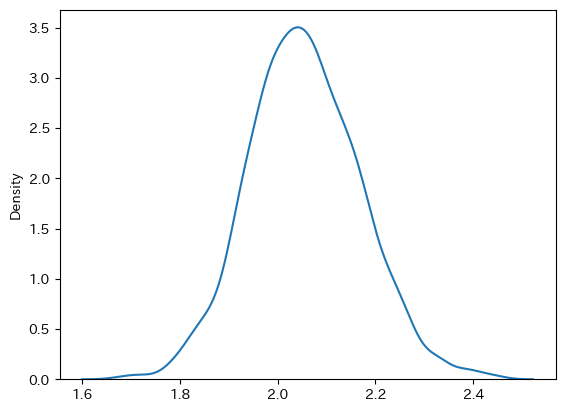

In [30]:
# 栄養量のオッズ比
sns.kdeplot(np.exp(n_b))

<Axes: ylabel='Density'>

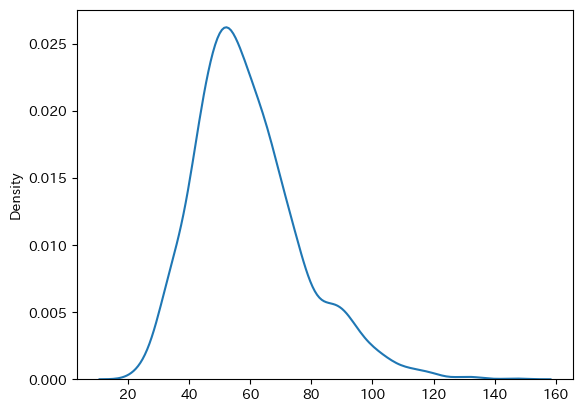

In [31]:
# 日照有のオッズ比
sns.kdeplot(np.exp(s_b))

## ロジスティック回帰曲線の描画(発芽数の期待値の分布)

### Deterministicに持っているデータで描画

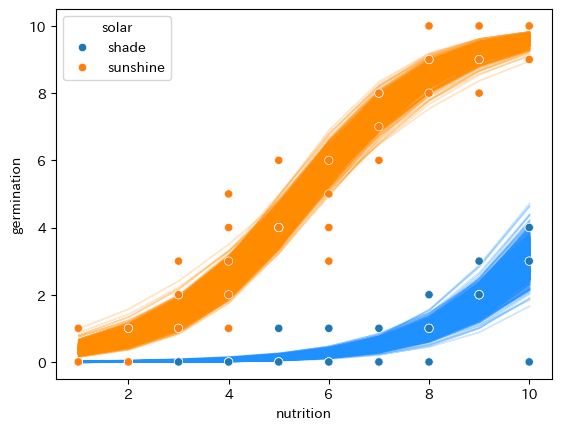

In [13]:
# 各天気における温度のデータを取得
sunshine_t = gmn_df[gmn_df["solar"]=="sunshine"]["nutrition"]
shade_t = gmn_df[gmn_df["solar"]=="shade"]["nutrition"]

# サンプリング結果から釣獲尾数の期待値を取得(今回は試行回数が全て10回なので、全体に10をかける)
y_preds = idata1["posterior"]["logistic_ratio"][0].values * 10

# y_predsから各天気の値に対応するインデックスを取得
sunshin_index = gmn_df[gmn_df["solar"]=="sunshine"].index.tolist()
shade_index = gmn_df[gmn_df["solar"]=="shade"].index.tolist()

# 晴れのポアソン回帰曲線
for i in range(y_preds.shape[0]):
    sunny_y_preds = y_preds[i][sunshin_index]
    sns.lineplot(x=sunshine_t, y=sunny_y_preds, color="darkorange", alpha=0.01, zorder=1)

# 曇りのポアソン回帰曲線
for i in range(y_preds.shape[0]):
    cloudy_y_preds = y_preds[i][shade_index]
    sns.lineplot(x=shade_t, y=cloudy_y_preds, color="dodgerblue", alpha=0.01, zorder=1)

# 観測データの散布図
ax = sns.scatterplot(x = gmn_parray["nutrition"], y = gmn_parray["germination"],
                     hue = gmn_parray["solar"], zorder=2)